In [1]:
import sys
import platform
import torch
import pandas as pd
import sklearn as sk

has_gpu = torch.cuda.is_available()
has_mps = torch.backends.mps.is_built()
device = "mps" if has_mps else "cuda" if torch.cuda.is_available() else "cpu"

print(f"Python Platform: {platform.platform()}")
print(f"PyTorch Version: {torch.__version__}")
print()
print(f"Python {sys.version}")
print(f"Pandas {pd.__version__}")
print(f"Scikit-Learn {sk.__version__}")
print("NVIDIA/CUDA GPU is", "available" if has_gpu else "NOT AVAILABLE")
print("MPS (Apple Metal) is", "AVAILABLE" if has_mps else "NOT AVAILABLE")
print(f"Target device is {device}")

Python Platform: Linux-6.1.58+-x86_64-with-glibc2.35
PyTorch Version: 2.1.0+cu121

Python 3.10.12 (main, Nov 20 2023, 15:14:05) [GCC 11.4.0]
Pandas 1.5.3
Scikit-Learn 1.2.2
NVIDIA/CUDA GPU is NOT AVAILABLE
MPS (Apple Metal) is NOT AVAILABLE
Target device is cpu


In [2]:
import numpy as np
import os

import torchvision
from torchvision import datasets, models
from torchvision.transforms import functional as FT
from torchvision import transforms as T
from torch import nn, optim
from torch.nn import functional as F
from torch.utils.data import DataLoader, sampler, random_split, Dataset
import copy
import math
from PIL import Image
import cv2
import albumentations as A

import matplotlib.pyplot as plt
%matplotlib inline

from pycocotools.coco import COCO
from albumentations.pytorch import ToTensorV2

import warnings
warnings.filterwarnings("ignore")
from collections import defaultdict, deque
import datetime
import time
from tqdm import tqdm
from torchvision.utils import draw_bounding_boxes

In [3]:
from torchvision.transforms import Compose, Resize, RandomHorizontalFlip, RandomVerticalFlip, ColorJitter, ToTensor, Normalize

def get_transforms():
    return Compose([
        Resize((600,600)),
        RandomHorizontalFlip(p=0.3),
        RandomVerticalFlip(p=0.3),
        ColorJitter(brightness=0.1, contrast=0.1),
        ToTensor(),
        #Normalize(mean=[0.48235, 0.45882, 0.40784], std=[0.00392156862745098, 0.00392156862745098, 0.00392156862745098]) #Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

In [4]:
class StrawberryDetection(datasets.VisionDataset):
    def __init__(self, root, split='train', transform=None, target_transform=None, transforms=None):
        super().__init__(root, transforms, transform, target_transform)
        self.split = split
        self.coco = COCO(os.path.join(root, split, "_annotations.coco.json"))
        self.ids = list(sorted(self.coco.imgs.keys()))
        self.ids = [id for id in self.ids if (len(self._load_target(id)) > 0)]
        self.transforms = get_transforms()  # Use torchvision transforms

    def _load_image(self, id: int):
        path = self.coco.loadImgs(id)[0]['file_name']
        image = Image.open(os.path.join(self.root, self.split, path)).convert("RGB")
        return image

    def _load_target(self, id):
        return self.coco.loadAnns(self.coco.getAnnIds(id))

    def __getitem__(self, index):
        id = self.ids[index]
        image = self._load_image(id)
        target = self._load_target(id)
        target = copy.deepcopy(target)

        # Original image size
        original_size = torch.tensor([image.width, image.height, image.width, image.height]).unsqueeze(0)

        # Process bboxes: COCO format (x_min, y_min, width, height) -> Convert to PyTorch format (x_min, y_min, x_max, y_max)
        boxes = [t['bbox'] for t in target]
        boxes = torch.tensor([[x, y, x + w, y + h] for x, y, w, h in boxes], dtype=torch.float32)

        # Rescale the bboxes in accordance with the image resizing
        new_size = torch.tensor([600, 600, 600, 600]).unsqueeze(0)  # New size after Resize((600, 600))
        boxes = boxes / original_size * new_size

        # Apply transforms to the image only
        if self.transforms is not None:
            image = self.transforms(image)

        targ = {}
        targ['boxes'] = boxes
        targ['labels'] = torch.tensor([t['category_id'] for t in target], dtype=torch.int64)
        targ['image_id'] = torch.tensor([index])
        targ['area'] = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        targ['iscrowd'] = torch.tensor([t.get('iscrowd', 0) for t in target], dtype=torch.int64)

        return image, targ

    def __len__(self):
        return len(self.ids)


In [5]:
%pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="OBJoOWV8KhCVSEC5pG8e")
project = rf.workspace("strawberries-fx9j1").project("10m-images")
dataset = project.version(11).download("coco")

loading Roboflow workspace...
loading Roboflow project...


In [7]:
dataset_path = "./10m-images-11/"
coco = COCO(os.path.join(dataset_path, "train", "_annotations.coco.json"))
categories = coco.cats
n_classes = len(categories.keys())
categories

loading annotations into memory...
Done (t=0.03s)
creating index...
index created!


{0: {'id': 0, 'name': 'weeds', 'supercategory': 'none'},
 1: {'id': 1, 'name': 'strawberry', 'supercategory': 'weeds'},
 2: {'id': 2, 'name': 'weed', 'supercategory': 'weeds'}}

In [8]:
classes = [i[1]['name'] for i in categories.items()]
classes

['weeds', 'strawberry', 'weed']

In [9]:
train_dataset = StrawberryDetection(root=dataset_path, transforms=get_transforms())
test_dataset = StrawberryDetection(root=dataset_path, split="test", transforms=get_transforms())

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


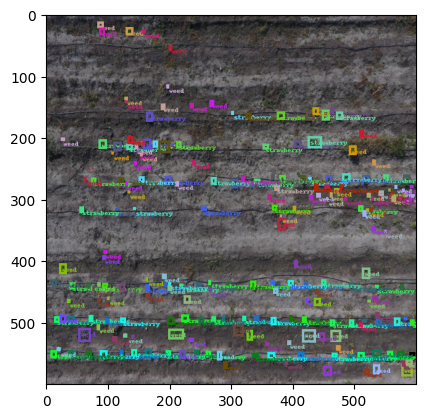

In [10]:
sample = train_dataset[3]
img_int = torch.tensor(sample[0] * 255, dtype=torch.uint8)
plt.imshow(draw_bounding_boxes(
	img_int, sample[1]['boxes'], [classes[i] for i in sample[1]['labels']], width=4
).permute(1, 2, 0))

In [11]:
def collate_fn(batch):
	return tuple(zip(*batch))

In [12]:
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, collate_fn=collate_fn)
print(train_loader)

In [13]:
from torchvision.models.detection import FasterRCNN_ResNet50_FPN_V2_Weights

model = models.detection.fasterrcnn_resnet50_fpn_v2(pretrained=True, weights=FasterRCNN_ResNet50_FPN_V2_Weights.COCO_V1)
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = models.detection.faster_rcnn.FastRCNNPredictor(in_features, n_classes)

In [14]:
images, targets = next(iter(train_loader))
images = list(image for image in images)
targets = [{k:v for k, v in t.items()} for t in targets]
output = model(images, targets)

In [15]:
model = model.to(device)

In [16]:
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9, weight_decay=0.0005)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

In [17]:
import sys

In [18]:
from tqdm import tqdm

def train_one_epoch(model, optimizer, loader, device, epoch):
    model.to(device)
    model.train()

    all_losses = []
    all_losses_dict = []

    for images, targets in tqdm(loader):
        images = list(image.to(device) for image in images)
        targets = [{k: torch.tensor(v).to(device) for k, v in t.items()} for t in targets]

        loss_dict = model(images, targets)
        print(loss_dict.keys())
        losses = sum(loss for loss in loss_dict.values())
        loss_dict_append = {k: v.item() for k, v in loss_dict.items()}
        loss_value = losses.item()

        all_losses.append(loss_value)
        all_losses_dict.append(loss_dict_append)

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

    # Convert list of dictionaries to a pandas DataFrame
    all_losses_dict = pd.DataFrame(all_losses_dict)

    # Calculate mean losses
    loss_bbox_reg_mean = all_losses_dict['bbox_regression'].mean() if 'bbox_regression' in all_losses_dict else 0
    loss_classification_mean = all_losses_dict['classification'].mean() if 'classification' in all_losses_dict else 0

    # Print summary
    print(f"Epoch {epoch}, lr: {optimizer.param_groups[0]['lr']:.6f}, "
          f"loss: {np.mean(all_losses):.6f}, "
          f"loss_bbox_reg: {loss_bbox_reg_mean:.6f}, "
          f"loss_classification: {loss_classification_mean:.6f}")

    scheduler.step()

    return all_losses_dict


In [ ]:
num_epochs = 10

for epoch in range(num_epochs):
	train_one_epoch(model, optimizer, train_loader, device, epoch)

  0%|          | 0/4 [00:00<?, ?it/s]

dict_keys(['loss_classifier', 'loss_box_reg', 'loss_objectness', 'loss_rpn_box_reg'])


 25%|██▌       | 1/4 [02:16<06:48, 136.15s/it]

dict_keys(['loss_classifier', 'loss_box_reg', 'loss_objectness', 'loss_rpn_box_reg'])


 50%|█████     | 2/4 [04:26<04:24, 132.46s/it]

dict_keys(['loss_classifier', 'loss_box_reg', 'loss_objectness', 'loss_rpn_box_reg'])


 75%|███████▌  | 3/4 [06:31<02:09, 129.31s/it]

dict_keys(['loss_classifier', 'loss_box_reg', 'loss_objectness', 'loss_rpn_box_reg'])


100%|██████████| 4/4 [08:35<00:00, 128.92s/it]


Epoch 0, lr: 0.001000, loss: 6.415438, loss_bbox_reg: 0.000000, loss_classification: 0.000000


  0%|          | 0/4 [00:00<?, ?it/s]

dict_keys(['loss_classifier', 'loss_box_reg', 'loss_objectness', 'loss_rpn_box_reg'])


 25%|██▌       | 1/4 [02:04<06:12, 124.08s/it]

dict_keys(['loss_classifier', 'loss_box_reg', 'loss_objectness', 'loss_rpn_box_reg'])


 50%|█████     | 2/4 [04:11<04:11, 125.80s/it]

dict_keys(['loss_classifier', 'loss_box_reg', 'loss_objectness', 'loss_rpn_box_reg'])


 75%|███████▌  | 3/4 [06:14<02:04, 124.58s/it]

dict_keys(['loss_classifier', 'loss_box_reg', 'loss_objectness', 'loss_rpn_box_reg'])


100%|██████████| 4/4 [08:18<00:00, 124.70s/it]


Epoch 1, lr: 0.001000, loss: 3.765870, loss_bbox_reg: 0.000000, loss_classification: 0.000000


  0%|          | 0/4 [00:00<?, ?it/s]

dict_keys(['loss_classifier', 'loss_box_reg', 'loss_objectness', 'loss_rpn_box_reg'])


 25%|██▌       | 1/4 [02:03<06:10, 123.35s/it]

dict_keys(['loss_classifier', 'loss_box_reg', 'loss_objectness', 'loss_rpn_box_reg'])


 50%|█████     | 2/4 [04:06<04:06, 123.36s/it]

dict_keys(['loss_classifier', 'loss_box_reg', 'loss_objectness', 'loss_rpn_box_reg'])


 75%|███████▌  | 3/4 [06:11<02:03, 123.99s/it]

dict_keys(['loss_classifier', 'loss_box_reg', 'loss_objectness', 'loss_rpn_box_reg'])


100%|██████████| 4/4 [08:17<00:00, 124.33s/it]


Epoch 2, lr: 0.001000, loss: 2.662123, loss_bbox_reg: 0.000000, loss_classification: 0.000000


  0%|          | 0/4 [00:00<?, ?it/s]

dict_keys(['loss_classifier', 'loss_box_reg', 'loss_objectness', 'loss_rpn_box_reg'])


 25%|██▌       | 1/4 [02:03<06:10, 123.48s/it]

dict_keys(['loss_classifier', 'loss_box_reg', 'loss_objectness', 'loss_rpn_box_reg'])


 50%|█████     | 2/4 [04:07<04:07, 123.51s/it]

dict_keys(['loss_classifier', 'loss_box_reg', 'loss_objectness', 'loss_rpn_box_reg'])


 75%|███████▌  | 3/4 [06:09<02:03, 123.05s/it]

dict_keys(['loss_classifier', 'loss_box_reg', 'loss_objectness', 'loss_rpn_box_reg'])


100%|██████████| 4/4 [08:14<00:00, 123.59s/it]


Epoch 3, lr: 0.001000, loss: 2.176861, loss_bbox_reg: 0.000000, loss_classification: 0.000000


  0%|          | 0/4 [00:00<?, ?it/s]

dict_keys(['loss_classifier', 'loss_box_reg', 'loss_objectness', 'loss_rpn_box_reg'])


 25%|██▌       | 1/4 [02:03<06:11, 123.95s/it]

dict_keys(['loss_classifier', 'loss_box_reg', 'loss_objectness', 'loss_rpn_box_reg'])


 50%|█████     | 2/4 [04:09<04:09, 124.60s/it]

dict_keys(['loss_classifier', 'loss_box_reg', 'loss_objectness', 'loss_rpn_box_reg'])


 75%|███████▌  | 3/4 [06:13<02:04, 124.63s/it]

dict_keys(['loss_classifier', 'loss_box_reg', 'loss_objectness', 'loss_rpn_box_reg'])


100%|██████████| 4/4 [08:18<00:00, 124.53s/it]


Epoch 4, lr: 0.001000, loss: 1.802984, loss_bbox_reg: 0.000000, loss_classification: 0.000000


  0%|          | 0/4 [00:00<?, ?it/s]

dict_keys(['loss_classifier', 'loss_box_reg', 'loss_objectness', 'loss_rpn_box_reg'])


 25%|██▌       | 1/4 [02:05<06:17, 125.94s/it]

dict_keys(['loss_classifier', 'loss_box_reg', 'loss_objectness', 'loss_rpn_box_reg'])


 50%|█████     | 2/4 [04:08<04:08, 124.04s/it]

dict_keys(['loss_classifier', 'loss_box_reg', 'loss_objectness', 'loss_rpn_box_reg'])


 75%|███████▌  | 3/4 [06:13<02:04, 124.43s/it]

dict_keys(['loss_classifier', 'loss_box_reg', 'loss_objectness', 'loss_rpn_box_reg'])


100%|██████████| 4/4 [08:17<00:00, 124.32s/it]


Epoch 5, lr: 0.000100, loss: 1.778477, loss_bbox_reg: 0.000000, loss_classification: 0.000000


  0%|          | 0/4 [00:00<?, ?it/s]

dict_keys(['loss_classifier', 'loss_box_reg', 'loss_objectness', 'loss_rpn_box_reg'])


 25%|██▌       | 1/4 [02:03<06:09, 123.30s/it]

dict_keys(['loss_classifier', 'loss_box_reg', 'loss_objectness', 'loss_rpn_box_reg'])


 50%|█████     | 2/4 [04:08<04:08, 124.43s/it]

dict_keys(['loss_classifier', 'loss_box_reg', 'loss_objectness', 'loss_rpn_box_reg'])


 75%|███████▌  | 3/4 [06:10<02:03, 123.44s/it]

dict_keys(['loss_classifier', 'loss_box_reg', 'loss_objectness', 'loss_rpn_box_reg'])


100%|██████████| 4/4 [08:15<00:00, 123.90s/it]


Epoch 6, lr: 0.000100, loss: 1.726143, loss_bbox_reg: 0.000000, loss_classification: 0.000000


  0%|          | 0/4 [00:00<?, ?it/s]

dict_keys(['loss_classifier', 'loss_box_reg', 'loss_objectness', 'loss_rpn_box_reg'])


 25%|██▌       | 1/4 [02:04<06:12, 124.01s/it]

dict_keys(['loss_classifier', 'loss_box_reg', 'loss_objectness', 'loss_rpn_box_reg'])


 50%|█████     | 2/4 [04:19<04:21, 130.83s/it]

dict_keys(['loss_classifier', 'loss_box_reg', 'loss_objectness', 'loss_rpn_box_reg'])


 75%|███████▌  | 3/4 [06:21<02:06, 126.82s/it]

dict_keys(['loss_classifier', 'loss_box_reg', 'loss_objectness', 'loss_rpn_box_reg'])


100%|██████████| 4/4 [08:24<00:00, 126.18s/it]


Epoch 7, lr: 0.000100, loss: 1.748067, loss_bbox_reg: 0.000000, loss_classification: 0.000000


  0%|          | 0/4 [00:00<?, ?it/s]

dict_keys(['loss_classifier', 'loss_box_reg', 'loss_objectness', 'loss_rpn_box_reg'])


 25%|██▌       | 1/4 [02:04<06:12, 124.32s/it]

dict_keys(['loss_classifier', 'loss_box_reg', 'loss_objectness', 'loss_rpn_box_reg'])


 50%|█████     | 2/4 [04:09<04:09, 124.97s/it]

dict_keys(['loss_classifier', 'loss_box_reg', 'loss_objectness', 'loss_rpn_box_reg'])


 75%|███████▌  | 3/4 [06:13<02:04, 124.59s/it]

In [1]:
import matplotlib.patches as patches

color_map = {class_name: plt.get_cmap("tab20")(i) for i, class_name in enumerate(classes)}

NameError: name 'classes' is not defined

In [ ]:
# Get a test image
img, _ = test_dataset[0]
img = img.to(device)

In [ ]:
# Get a test image
img, _ = test_dataset[0]
img = img.to(device)

# Set the model to evaluation mode
model.eval()

# Make predictions
with torch.no_grad():
    prediction = model([img])  # Ensure img is on the correct device
    pred = prediction[0]

# Convert the image tensor to the same format as used for visualization in cell 11
img_for_display = img.cpu().detach().numpy()
if img_for_display.max() <= 1.0:
    # Assuming the tensor is normalized between 0 and 1, rescale it to 0-255.
    img_for_display = (img_for_display * 255).astype(np.uint8)

# Draw the predictions on the image
fig, ax = plt.subplots(1, figsize=(12, 9))
ax.imshow(img_for_display.transpose(1, 2, 0))  # Transpose to convert to HxWxC format

# Lower the confidence threshold to check for any detections
confidence_threshold = 0.1  # Example threshold

# Filter out the predictions based on the confidence
scores = pred['scores'].cpu().numpy()
pred_boxes = pred['boxes'].cpu().numpy()[scores > confidence_threshold]
pred_labels = pred['labels'].cpu().numpy()[scores > confidence_threshold]
scores = scores[scores > confidence_threshold]

# Draw the bounding boxes and labels on the image
for box, label, score in zip(pred_boxes, pred_labels, scores):
    label_name = classes[label]
    color = color_map[label_name]
    rect = patches.Rectangle((box[0], box[1]), box[2] - box[0], box[3] - box[1], linewidth=2,
                             edgecolor=color, facecolor='none')
    ax.add_patch(rect)
    ax.text(box[0], box[1], f'{label_name}: {score:.2f}', bbox=dict(facecolor='yellow', alpha=0.5),
            fontsize=6, color='black')

# Show the final figure with bounding boxes
ax.axis('off')
plt.show()